<a href="https://colab.research.google.com/github/Ishu335/Project/blob/main/Image_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving cycle.jpg to cycle (1).jpg


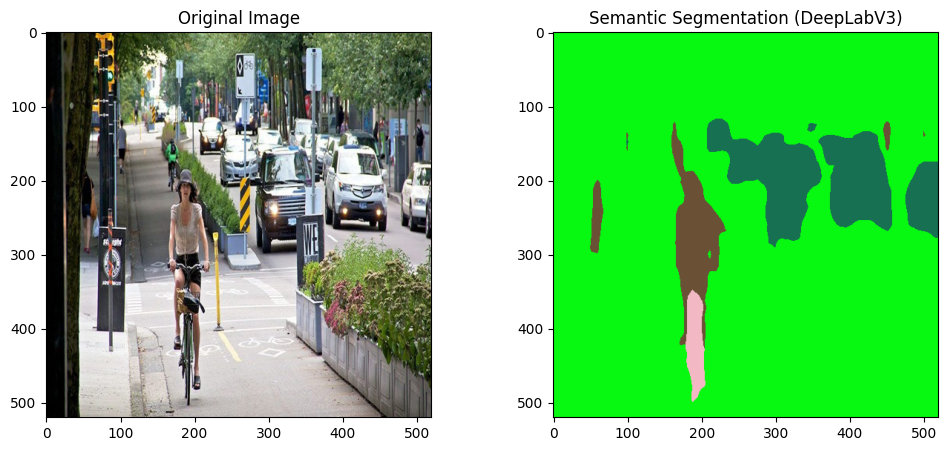

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 149MB/s]


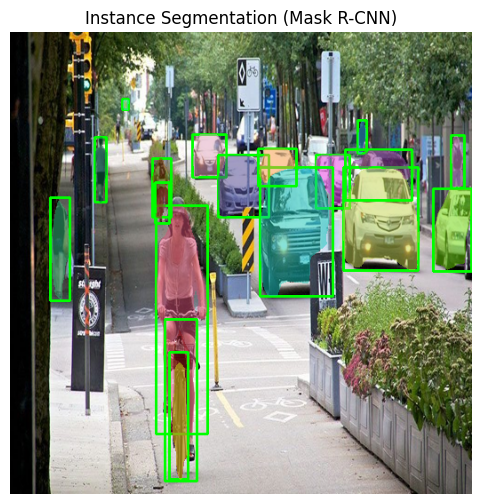

In [7]:
# Install required libraries
!pip install opencv-python matplotlib torch torchvision

# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
from PIL import Image
import io
from google.colab import files

# Upload an image
uploaded = files.upload()
for fn in uploaded:
    image = Image.open(io.BytesIO(uploaded[fn])).convert("RGB")
    image = image.resize((520, 520))
    image_np = np.array(image)
    break

# -------- SEMANTIC SEGMENTATION (DeepLabV3) --------
# Preprocess image
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(image).unsqueeze(0)

# Load DeepLabV3 model
model_semantic = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# Run inference
with torch.no_grad():
    output = model_semantic(input_tensor)['out'][0]
output_predictions = output.argmax(0).byte().cpu().numpy()

# Generate colored mask
colors = np.random.randint(0, 255, size=(21, 3), dtype=np.uint8)
colored_mask = colors[output_predictions]

# Plot Semantic Segmentation result
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("Semantic Segmentation (DeepLabV3)")
plt.imshow(colored_mask)

plt.show()

# -------- INSTANCE SEGMENTATION (Mask R-CNN) --------
# Preprocess for Mask R-CNN
transform_instance = transforms.Compose([
    transforms.ToTensor()
])
input_tensor_instance = transform_instance(image).unsqueeze(0)

# Load Mask R-CNN model
from torchvision.models.detection import maskrcnn_resnet50_fpn
model_instance = maskrcnn_resnet50_fpn(pretrained=True).eval()

# Run inference
with torch.no_grad():
    prediction = model_instance(input_tensor_instance)[0]

# Draw masks and bounding boxes
image_draw = image_np.copy()

for i in range(len(prediction['boxes'])):
    score = prediction['scores'][i].item()
    if score >= 0.7:
        box = prediction['boxes'][i].cpu().numpy().astype(int)
        mask = prediction['masks'][i, 0].cpu().numpy()
        mask = (mask > 0.5).astype(np.uint8)

        cv2.rectangle(image_draw, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

        color_mask = np.random.randint(0, 255, (1, 3), dtype=np.uint8)
        image_draw[mask == 1] = image_draw[mask == 1] * 0.5 + color_mask * 0.5

# Plot Instance Segmentation result
plt.figure(figsize=(10, 6))
plt.imshow(image_draw)
plt.title('Instance Segmentation (Mask R-CNN)')
plt.axis('off')
plt.show()
